This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with PSO search according to the convolution of PICP and PINRW criteria
Some code block below imply that you make a completely new PSO search, some allow you to use precomputed data. Rely to the markdowns above the blocks

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [4]:
!pip show pymoo || pip install pymoo
from pymoo.core.problem import ElementwiseProblem


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 6.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.1 MB/s eta 0:00:00:00:01
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=8b8aa8a7703e5ea968a425dade87281750b6712a49e5323df78f1b5a303fefbb
  Stored in directory: /home/alexander/.cache/pip/wheels/91/a8/bc/5b55a10f763ee2c066ff2d94058d7dd64d570fc45adc027b3d
Successfully built grapheme


In [5]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [6]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [7]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [8]:
df.head()

,<DATE>,<CLOSE>
0,2003-03-03,352.24
1,2003-03-04,348.40
2,2003-03-05,357.65
3,2003-03-06,359.97
4,2003-03-07,354.87


In [9]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [10]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [11]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


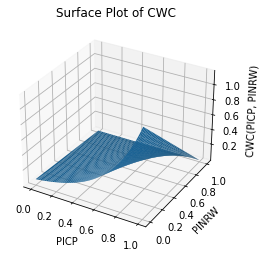

Maximum value of Z: 1.1583539630298554
Corresponding PICP and PINRW values: 0.999 0.0


In [12]:
#here we can investigate the etta and mu influence on the convolution surface shape

from mpl_toolkits.mplot3d import Axes3D

etta = 3
mu = 0.95

x = np.arange(0, 1, 0.001)
y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
Z = (1-Y) * (np.exp(etta * (X - mu)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('PICP')
ax.set_ylabel('PINRW')
ax.set_zlabel('CWC(PICP, PINRW)')
ax.set_title('Surface Plot of CWC')

plt.show()

max_value = np.max(Z)
max_index = np.unravel_index(np.argmax(Z), Z.shape)
max_x = X[max_index]
max_y = Y[max_index]

print("Maximum value of Z:", max_value)
print("Corresponding PICP and PINRW values:", max_x, max_y)

In [13]:
def CWC(y_true, y_pred, etta = 3, mu = 0.95):

    return (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu))))


In [14]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [15]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [16]:
df[:train_size].tail()

,<DATE>,<CLOSE>
4003,2019-03-11,2465.94
4004,2019-03-12,2468.25
4005,2019-03-13,2470.61
4006,2019-03-14,2457.79
4007,2019-03-15,2476.73


In [17]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))

In [62]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [63]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [20]:
X_train.shape

(4007, 1)

In [21]:
y_train.shape

(4007, 1)

In [22]:
X_test.shape

(1001, 1)

In [23]:
y_test.shape

(1001, 1)

Check that y is shifted 1 point ahead of X:

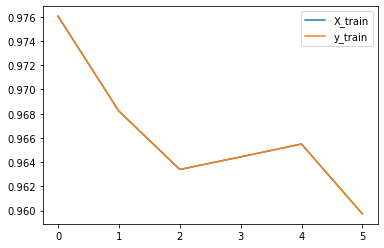

In [24]:
plt.plot(X_train[-6:], label='X_train')
plt.plot(y_train[-7:-1], label='y_train')
plt.legend()
plt.show()

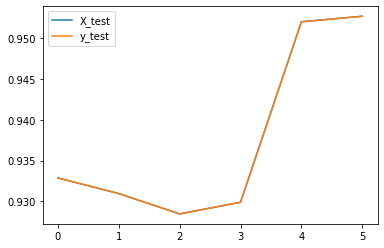

In [25]:
plt.plot(X_test[-6:], label='X_test')
plt.plot(y_test[-7:-1], label='y_test')
plt.legend()
plt.show()

In [26]:
# Define the model
model = Sequential([
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

2023-11-04 15:42:45.810451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-04 15:42:45.810769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-04 15:42:45.810854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-04 15:42:45.810931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [ ]:
def evaluate_nn(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    for weights in W:
        model.set_weights(set_shape(weights,shape))
        predictions = model.predict(X_train)
        solution_fitness = 1-CWC(Y_train, predictions).numpy() / max_value
        results.append(solution_fitness)
    return results

2023-09-10 20:48:24.229545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-09-10 20:48:24.229632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-09-10 20:48:24.229701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-09-10 20:48:24.229770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [ ]:
import random


def evaluate_picp_pinrw(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    i = 1
    for iteration in W:
        print("=== Iteration number ===", i)
        #if i == 358:
        #    break 
        i = i + 1
            #random_number = random.randint(0, 29)
        for weights in iteration:
            #weights = iteration[random_number]
            model.set_weights(set_shape(weights,shape))
            predictions = model.predict(X_train)
            picp = PICP(Y_train, predictions)
            pinrw = PINRW(predictions)
            results.append([picp.numpy(), pinrw.numpy()])
    return results

In [44]:
shape = get_shape(model)
x_max = 1.0 * np.ones(model.count_params())
x_min = -1.0 * x_max
bounds = (x_min, x_max)

In [45]:
model.count_params()

26

In [49]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=model.count_params(),
                         n_obj=2,
                         xl=np.full(model.count_params(), -1),
                         xu=np.full(model.count_params(), 1)
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        global model, shape, X_train, y_train
        model.set_weights(set_shape(x,shape))
        predictions = model.predict(X_train)
        f1 = 1 - PICP(y_train, predictions)
        f2 = PINRW(predictions)

        out["F"] = [f1, f2]

problem = MyProblem()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [39]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



In [40]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 500)

In [50]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

126/126 [==============================] - 0s 651us/step
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      4 |             - |             -
126/126 [==============================] - 0s 639us/step
     2 |       50 |      5 |  0.0873247036 |         ideal
126/126 [==============================] - 0s 640us/step
     3 |       60 |      6 |  0.0402550462 |             f
126/126 [==============================] - 0s 635us/step
     4 |       70 |      6 |  0.000000E+00 |             f
126/126 [==============================] - 0s 633us/step
     5 |       80 |      5 |  0.0622384423 |             f
126/126 [==============================] - 0s 638us/step
     6 |       90 |      5 |  0.000000E+00 |             f
126/126 [==============================] - 0s 864us/step
     7 |      100 |      5 |  0.000000E+00 |             f
126/126 [==============================] - 0s 603us/step
     8 |      110 |      6 |  0.0194143240 |             f
126/126 [====

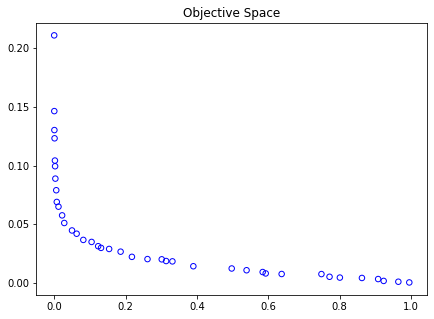

In [51]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [58]:
model.set_weights(set_shape(X[3],shape))

<H1> Predictions section:

In [65]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

32/32 [==============================] - 0s 705us/step


In [67]:
y_test = scaler.inverse_transform(y_test)

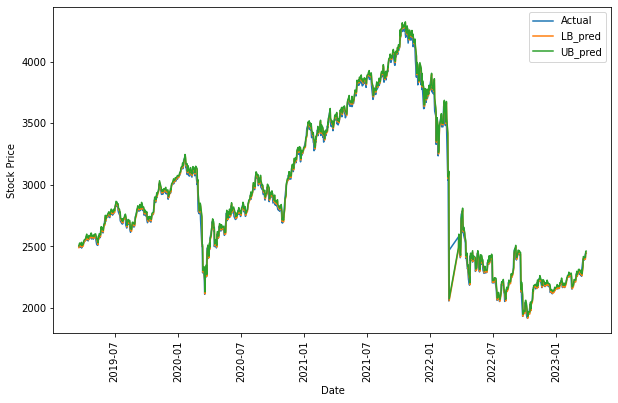

In [68]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(test['<DATE>'][2:], y_test[1:], label='Actual')

ax.plot(test['<DATE>'][1:], y_pred[:,0], label='LB_pred')
ax.plot(test['<DATE>'][1:], y_pred[:,1], label='UB_pred')


ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()

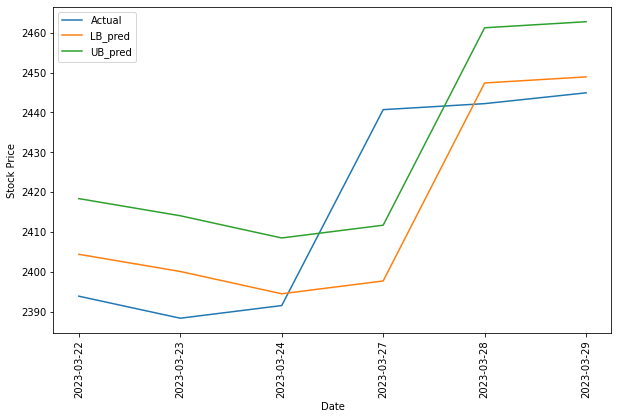

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

last_dates = ('2023-03-22','2023-03-23','2023-03-24','2023-03-27','2023-03-28','2023-03-29')

ax.plot(last_dates, y_test[-6:], label='Actual')

ax.plot(last_dates, y_pred[-6:,0], label='LB_pred')
ax.plot(last_dates, y_pred[-6:,1], label='UB_pred')

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()